# Quant Research Project - Eden Jenson


## Part 1 
### For this part of the project we implement a z-score based strategy

In [1]:
import pandas as pd 
from scipy.interpolate import interp1d
import numpy as np
from pandas import Timedelta
import statsmodels.api as sm 
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from talib import RSI, BBANDS, MACD
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [2]:
df=pd.read_parquet('data.parquet',engine= 'fastparquet')
df=df.resample('30T', offset=Timedelta(minutes=15)).mean().between_time('09:15:00', '15:30:00')
df= df.interpolate(method='linear')
df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.278628,0.196031,27.0
2021-01-01 09:45:00,0.268718,0.191299,27.0
2021-01-01 10:15:00,0.267698,0.190125,27.0
2021-01-01 10:45:00,0.266031,0.188130,27.0
2021-01-01 11:15:00,0.264924,0.187772,27.0
...,...,...,...
2022-06-30 13:15:00,0.239838,0.215831,28.0
2022-06-30 13:45:00,0.239862,0.214812,28.0
2022-06-30 14:15:00,0.239037,0.213721,28.0


### It is necessary for a pairs trading strategy to have the pairs exhibiting cointegration, we will test for this using the Engle Granger Tests

In [3]:
#Engle Granger tests
_, pvalue, _ = coint(df['banknifty'],df['nifty'])

if pvalue <0.05:
    print("The time series are cointegrated.")
else:
    print("The time series are not cointegrated.")
    


The time series are cointegrated.


<Axes: xlabel='time'>

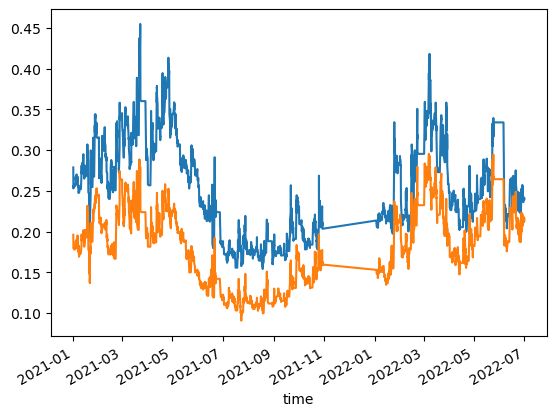

In [4]:
df['banknifty'].plot()
df['nifty'].plot()

## Establishing the Base strategy.
 In order to address the substantial gaps in our dataset and with the intention to employ a machine learning-based strategy for the upcoming stages, we are segregating the data into training and testing sets.

The base strategy aims to establish a Z-score-based approach for the spread between BANKNIFTY IV and NIFTY IV. This involves computing the Z-score by utilizing shorter and longer moving averages of the spread. Throughout the remainder of the project, we will treat this spread as an independent asset class.

The entry criteria, a threshold of 1 is defined. If the Z-score deviates above 1, we initiate a short position on the spread. Conversely, if the Z-score falls below -1, we initiate a long position on the spread

The exit criteria, if a long trade is active and the Z-score exceeds 0, we exit the position. Conversely, if a short trade is active and the Z-score goes below 0, we exit the position. Additionally, if a signal is triggered for a position that is already active, we exit that position and re-enter at that specific point in time.




In [5]:
df['spread']= df['banknifty'] - df['nifty']
train= df.loc[:'2021-10-29 15:15:00'].copy()
test= df.loc['2022-01-03 09:15:00':].copy()

def process_df(df, shorter_window, longer_window):
    rolling_train_std = df['spread'].rolling(longer_window).std()
    zero_std_mask = rolling_train_std == 0

    df['shorter_ma'] = df['spread'].rolling(window=shorter_window).mean()
    df['longer_ma'] = df['spread'].rolling(window=longer_window).mean()
    df['z_score'] = np.where(zero_std_mask, 0, (df['shorter_ma'] - df['longer_ma']) / rolling_train_std)
    
    threshold = 1 
    df['entry_signal'] = np.where(df['z_score'] > threshold, -1, np.where(df['z_score'] < -threshold, 1, 0))
    df['entry_p_l'] = np.where(df['entry_signal'] != 0, df['spread'] * (df['tte']) ** 0.7, 0)
    
    max_trade_duration = pd.Timedelta(days=5)

    df['exit_p_l'] = 0 
    entry_index_long, entry_index_short = None, None

    for index, row in df.iterrows():
        if row['entry_signal'] == 1 and entry_index_long is None:
            entry_index_long = index

        elif row['z_score'] > 0 and entry_index_long is not None:
            df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_long = None
        elif row['entry_signal']==1 and entry_index_long is not None:
            df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_long = index

        if row['entry_signal'] == -1 and entry_index_short is None:
            entry_index_short = index

        elif row['z_score'] < 0 and entry_index_short is not None:
            df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_short = None
        elif row['entry_signal'] == -1 and entry_index_short is not None:
            df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_long = index
            
        if entry_index_long or entry_index_short:
            trade_duration = index - entry_index_long if entry_index_long else index - entry_index_short
            if trade_duration >= max_trade_duration:
                df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                entry_index_long, entry_index_short = None, None

    return df


    

### Creating the Ratios

In [6]:

def calculate_years_past(series):
    minutes_in_a_day = 24 * 60  # 24 hours * 60 minutes
    start_date = series.index[0].timestamp()  # Convert Timestamp to seconds
    end_date = series.index[-1].timestamp()

    # Convert start and end dates to minutes
    minutes_difference = (end_date - start_date) / 60
    years = minutes_difference / (365 * minutes_in_a_day)

    return years
    

def calculate_sharpe_ratio(series, return_series):
    years=calculate_years_past(series)    
    entries_per_year = return_series.shape[0] / years
    expected_return= return_series.mean() * entries_per_year
    volatility= return_series.std() * np.sqrt(entries_per_year)
    benchmark= 0.072 # risk free rate: 5 year bond in India 
    return (expected_return-benchmark)/(volatility)
    
def calculate_max_drawdown(return_series):
    cumulative_returns= (1+pd.Series(return_series)).cumprod()
    cumulative_max=cumulative_returns.cummax()
    drawdown_series= -((cumulative_returns/cumulative_max) -1 )
    max_drawdown= drawdown_series.max()
    return max_drawdown



## Preparing the backtest function

In [7]:
def trades(df, shorter_window, longer_window):
    df = process_df(df, shorter_window, longer_window)
    exit_df = df[df['exit_p_l'] != 0]
    entry_df = df[df['entry_p_l'] != 0]

    result_frames = []
    previous_iteration_entries = pd.Series()

    for _, exit_row in exit_df.iterrows():
        mask = (entry_df.index >= pd.Series(exit_df.index).shift(1).fillna('2021-01-01 09:15:00').loc[0]) & (entry_df.index < exit_row.name)
        filtered_entries = entry_df.loc[mask, ['entry_p_l', 'entry_signal']].reset_index()
        new_entries = filtered_entries[~filtered_entries['entry_p_l'].isin(previous_iteration_entries)]
        position = new_entries['entry_signal'].max()
        iteration_df = pd.DataFrame({'entry_p_l': [new_entries['entry_p_l'].mean()], 'num_entries': [len(new_entries)], 'position': [position], 'datetime': [filtered_entries.iloc[-1]['time']]})
        result_frames.append(iteration_df)
        previous_iteration_entries = pd.concat([previous_iteration_entries, filtered_entries['entry_p_l']])

    if not result_frames:
        #print(f"No trades for shorter_window={shorter_window}, longer_window={longer_window}")
        return None

    result_df = pd.concat(result_frames, ignore_index=True)
    result_df.index = exit_df.index

    profit_df = pd.merge(exit_df, result_df, left_index=True, right_index=True)[['exit_p_l', 'entry_p_l_y', 'num_entries', 'position']]

    profit_df['trade_p_l'] = np.where(profit_df['position'] == 1, profit_df['exit_p_l'] - profit_df['entry_p_l_y'],
                                      np.where(profit_df['position'] == -1, profit_df['entry_p_l_y'] - profit_df['exit_p_l'], 0))

    profit_df['trade_return'] = np.where(profit_df['position'] == 1, (profit_df['exit_p_l'] / profit_df['entry_p_l_y']) - 1,
                                         np.where(profit_df['position'] == -1, (profit_df['entry_p_l_y'] / profit_df['exit_p_l']) - 1, 0))
    profit_df['total_p_l'] = profit_df['num_entries'] * profit_df['trade_p_l']

    Profit = profit_df['total_p_l'].sum()
    Sharpe_Ratio = calculate_sharpe_ratio(profit_df['total_p_l'], profit_df['trade_return'])
    Max_Drawdown = calculate_max_drawdown(profit_df['trade_return'])
    return Profit, Sharpe_Ratio, Max_Drawdown


### Optimising the window range and finding the optimal window range that gives the optimal combination the  P/L, Sharpe Ratio, and  Max Drawdown

In [8]:


shorter_window_range = range(5, 50, 5)
longer_window_range = range(10, 100, 10)

# Results storage
best_shorter_window = None
best_longer_window = None
best_profit = float('-inf')
best_sharpe_ratio = float('-inf')
best_max_drawdown = float('inf')
best_combination_score = float('-inf')

# Iterate over parameter combinations
for shorter_window, longer_window in product(shorter_window_range, longer_window_range):
    result = trades(test, shorter_window, longer_window)
    
    if result is not None:
        Profit, Sharpe_Ratio, Max_Drawdown = result
        
        # Exclude combinations with infinite Sharpe ratio
        if Sharpe_Ratio != float('inf'):
            # Calculate combination score for the current combination
            combination_score = Sharpe_Ratio + Profit + 1 / Max_Drawdown

            # Update best results if current combination score is better
            if combination_score > best_combination_score:
                best_shorter_window = shorter_window
                best_longer_window = longer_window
                best_profit = Profit
                best_sharpe_ratio = Sharpe_Ratio
                best_max_drawdown = Max_Drawdown
                best_combination_score = combination_score


print(f"Best Shorter Window: {best_shorter_window}")
print(f"Best Longer Window: {best_longer_window}")
print(f"Best Profit: {best_profit}")
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")
print(f"Best Max Drawdown: {best_max_drawdown}")
print(f"Best Combination Score: {best_combination_score}")

Best Shorter Window: 35
Best Longer Window: 80
Best Profit: 0.6271019301654844
Best Sharpe Ratio: 3.2752516227366666
Best Max Drawdown: 0.13181053838009926
Best Combination Score: 11.489000358913376


# Part 2 

## This my proposed strategy
#### The first step is to figure out the features and obtain insights into how the spread behaves. Then the target variable is created based on observations.

In [9]:
from talib import RSI, BBANDS, MACD

def create_proposed_strategy(trade_df, threshold):
# Creating basic features
    trade_df=df.copy()
    trade_df['spread_ma5'] = trade_df['spread'].rolling(window=5).mean()
    trade_df['spread_ma20'] = trade_df['spread'].rolling(window=20).mean()

    # Lagged terms
    trade_df['spread_lag'] = trade_df['spread'].shift(1)
    trade_df['spread_mag5_lag'] = trade_df['spread_ma5'].shift(1)
    trade_df['volatility_5_lag'] = trade_df['spread_lag'].rolling(window=5).std()
    trade_df['volatility_20_lag'] = trade_df['spread_lag'].rolling(window=20).std()

    trade_df['spread_log'] = np.log(trade_df['spread'])
    trade_df['spread_exp'] = np.exp(trade_df['spread'])
    trade_df['volatility_5'] = trade_df['spread'].rolling(window=5).std()
    trade_df['volatility_20'] = trade_df['spread'].rolling(window=20).std()
    trade_df['spread_ema_5'] = trade_df['spread'].ewm(span=5).mean()
    trade_df['spread_ema_20'] = trade_df['spread'].ewm(span=20).mean()
    trade_df['roc'] = (trade_df['spread'] / trade_df['spread'].shift(5) - 1) * 100

    # Interaction terms
    trade_df['spread_movement_interaction'] = trade_df['spread'].pct_change() * trade_df['spread_lag'].pct_change()
    trade_df['volatility_ma_interaction'] = trade_df['volatility_5'] * trade_df['volatility_20']
    trade_df['spread_volatility_interaction'] = trade_df['spread'] * trade_df['volatility_5']

    # Technical indicator on spread
    trade_df['rsi'] = RSI(trade_df['spread'], timeperiod=threshold)
    # Creating a mean-reverting signal based on RSI
    trade_df['rsi_log'] = RSI(trade_df['spread_log'], timeperiod=threshold)
    # Creating a mean-reverting signal based on RSI
    trade_df['rsi_signal'] = 0
    trade_df.loc[trade_df['rsi_log'] > 70, 'rsi_signal'] = -1
    trade_df.loc[trade_df['rsi_log'] < 30, 'rsi_signal'] = 1
    trade_df['rsi_diff'] = trade_df['rsi_log'].diff()
    total_target= (
        trade_df['rsi_diff']    )
    trade_df['target'] = np.where(total_target > 0, -1, np.where(total_target == 0, 1, 0))

    trade_df=trade_df.dropna()
    return trade_df


 A pattern emerges when examining the relationship between the difference of the RSI values (RSI.diff()) and the log value of the spread. The objective is to leverage predictive insights and capitalise on potential opportunities

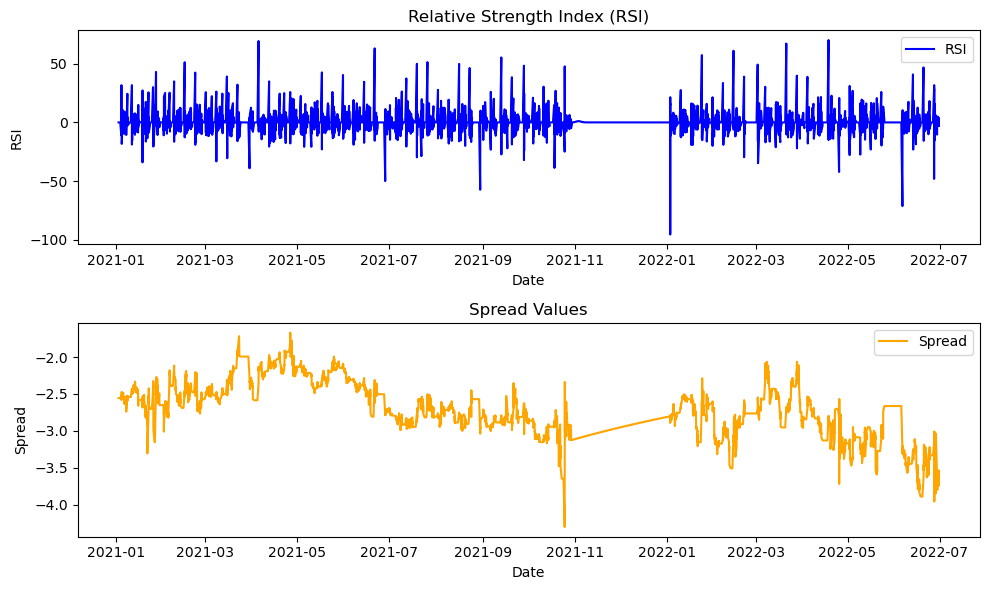

In [10]:
trade_df=create_proposed_strategy(df, 14)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(trade_df.index, trade_df['rsi_diff'], label='RSI', color='blue')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

# Plot Spread
plt.subplot(2, 1, 2)
plt.plot(trade_df.index, trade_df['spread_log'], label='Spread', color='orange')
plt.title('Spread Values')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()

plt.tight_layout()
plt.show()


 By using mutual information we can gauge the strength of the relatinship between each feature and the target. The top 5 of these features are chosen.

In [11]:
from sklearn.feature_selection import mutual_info_classif
def preprocess_data(threshold):
    trade_df= create_proposed_strategy(df.copy(), threshold= threshold)
    y=trade_df['target']
    X=trade_df.drop([y.name,'nifty','banknifty'],axis=1)
    mi_scores = mutual_info_classif(X,y)
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
    mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)
    selected_features = mi_df.nlargest(5, 'Mutual_Information')['Feature'].tolist()

    trade_train = trade_df.loc[:'2021-10-29 15:15:00'].copy()
    trade_test= trade_df.loc['2022-01-03 09:15:00':].copy()
    y_train= trade_train['target']
    X_train= trade_train[selected_features]
    y_test= trade_test['target']
    X_test= trade_test[selected_features]
    return trade_train, trade_test, y_train, X_train, y_test, X_test



In [12]:
trade_df= create_proposed_strategy(df.copy(), threshold= 14)
y=trade_df['target']
X=trade_df.drop([y.name,'nifty','banknifty'],axis=1)
mi_scores = mutual_info_classif(X,y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)
mi_df

,Feature,Mutual_Information
21,rsi_diff,0.728581
15,spread_movement_interaction,0.379315
14,roc,0.325162
18,rsi,0.322215
17,spread_volatility_interaction,0.314862
19,rsi_log,0.312244
10,volatility_5,0.254442
16,volatility_ma_interaction,0.241403
4,spread_lag,0.238163
6,volatility_5_lag,0.232942


We consider using ensemble methods as they are effective in modelling non linear relationships between input features and the target variable. Additionally, SVMs, with their ability to handle non-linear problems, are evaluated for accuracy in our specific case.
To offset issues related to overfitting and prevent data leakages, we opt for timeseries cross-validation as a robust validation strategy.

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid


def time_series_cross_validation(model, X_train, y_train, X_test, y_test, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, _ in tscv.split(X_train):
        X_train_cv, y_train_cv = X_train.iloc[train_index], y_train.iloc[train_index]
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test)
        
        
    return y_pred

trade_train, trade_test, y_train, X_train, y_test, X_test=preprocess_data(14)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred_rf = time_series_cross_validation(rf_model, X_train, y_train, X_test, y_test, n_splits=5)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy RF:",accuracy_rf)

svm_model = SVC(kernel='poly', degree=2, C=1.0)
y_pred_svm= time_series_cross_validation(svm_model, X_train, y_train, X_test, y_test, n_splits=5)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy SVM:",accuracy_svm)

gb_model= GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
y_pred_gb= time_series_cross_validation(gb_model, X_train, y_train, X_test, y_test, n_splits=5)
accuracy_gb= accuracy_score(y_test, y_pred_gb)
print("Accuracy GB:",accuracy_gb)



Accuracy RF: 0.8560378169316717
Accuracy SVM: 0.7490330898152128
Accuracy GB: 0.857327030511388


From the accuracy scores, the ensemble methods are clearly preferable, we will use random forest since it provides a high degree of accuracy with a much faster computation time

## We will now define the entry and exit conditions
### Entry Conditions.
#### Long Position (Signal = 1): 
* We initiate a long position when our predictive model signals an entry with a value of 1. This indicates a bullish RSI divergence, prompting us to take a positive stance on the spread

#### Short Position (Signal = -1):
* A signal value of -1 suggests a bearish scenario. In response, we enter a short position, anticipating a downward movement in the spread.

### Exit Conditions.
#### Exiting Long Positions : 
* The model signals a new entry with a value of -1, indicating bearishness in the spread. 
* The model re- enters a long position, wherein which we exit and re-enter at that point in time 

#### Exiting Short Positions : 
* The model signals a new entry with a value of 1, indicating bullishness in the spread. 
* The model re- enters a short position , wherein which we exit and  re-enter at that point in time 

In [14]:

def process_predictions(trade_test,y_test,y_pred):
    
    predictions_df = pd.DataFrame({'spread': trade_test['spread'],'tte': trade_test['tte'],'actual_signal': y_test,
    'Predictions': y_pred,
    'entry_p_l': 0,
    'exit_p_l': 0
}, index=X_test.index)

    entry_index_long, entry_index_short = None, None
    max_trade_duration = pd.Timedelta(days=5)
    predictions_df['entry_p_l'] = np.where(predictions_df['Predictions'] != 0, predictions_df['spread'] * (predictions_df['tte']) ** 0.7, 0)

    for index, row in predictions_df.iterrows():
        if row['Predictions'] == 1 and entry_index_long is None:
            entry_index_long = index
        elif row['Predictions'] == -1 and entry_index_long is not None:
            predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_long = None
        elif row['Predictions']== 1 and entry_index_long is not None: 
            predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            predictions_df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_long= index
            
        if row['Predictions'] == -1 and entry_index_short is None:
            entry_index_short = index
        elif row['Predictions'] == 1 and entry_index_short is not None:
            predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_short = None
        elif row['Predictions']==-1 and entry_index_short is not None:
            predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
            predictions_df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
            entry_index_short= index

        if entry_index_long or entry_index_short:
            trade_duration = index - entry_index_long if entry_index_long else index - entry_index_short
            if trade_duration >= max_trade_duration:
                if entry_index_long is not None:
                    predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                    entry_index_long = None
                elif entry_index_short is not None:
                    predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                    entry_index_short = None
    return predictions_df



## Preparing the backtest function

In [15]:

def trades(entry_df,exit_df):
    result_frames = []
    previous_iteration_entries = pd.Series()

    for _, exit_row in exit_df.iterrows():
        mask = (entry_df.index >= pd.Series(exit_df.index).shift(1).fillna('2021-01-01 09:15:00').loc[0]) & (entry_df.index < exit_row.name)
        filtered_entries = entry_df.loc[mask, ['entry_p_l', 'Predictions']].reset_index()
        new_entries = filtered_entries[~filtered_entries['entry_p_l'].isin(previous_iteration_entries)]
        position = new_entries['Predictions'].max()
        iteration_df = pd.DataFrame({'entry_p_l': [new_entries['entry_p_l'].mean()],'num_entries': [len(new_entries)],'position': [position],'datetime': [filtered_entries.iloc[-1]['time']]})
        result_frames.append(iteration_df)
        previous_iteration_entries = pd.concat([previous_iteration_entries, filtered_entries['entry_p_l']])

    if not result_frames:
        print(f"No trades for shorter_window={shorter_window}, longer_window={longer_window}")

    result_df = pd.concat(result_frames, ignore_index=True)
    result_df.index = exit_df.index
    profit_df = pd.merge(exit_df, result_df, left_index=True, right_index=True)[['exit_p_l', 'entry_p_l_y', 'num_entries', 'position']]
    profit_df['trade_p_l'] = np.where(profit_df['position'] == 1,profit_df['exit_p_l'] - profit_df['entry_p_l_y'],
                                      np.where(profit_df['position'] == -1,profit_df['entry_p_l_y'] - profit_df['exit_p_l'],0))
    profit_df['trade_return'] = np.where(profit_df['position'] == 1,(profit_df['exit_p_l'] / profit_df['entry_p_l_y']) - 1,
        np.where(profit_df['position'] == -1,(profit_df['entry_p_l_y'] / profit_df['exit_p_l']) - 1,0))
    profit_df['total_p_l'] = profit_df['num_entries'] * profit_df['trade_p_l']
    return profit_df


## Optimising the model and the threshold 
### The goal of this optimisation is to 
* Hyper parameter grid search : we conduct a grid search over a predefined set  of hyperparameters for the Random forest Classifier
* Threshold Variation : the optimisation considers various threshold values for the RSI indicator, by testing with various thresholds we attempt to maximise the overall profit
* The goal of the optmisation is find the parameter and threshold value that leads to the most optimal combination of the P/L, Sharpe Ratio and the Max Drawdown.


In [16]:
def evaluate_model(params, threshold, trade_test, X_train, y_train, X_test, y_test, n_splits=5):
    model = RandomForestClassifier(**params, random_state=42)
    y_pred = time_series_cross_validation(model, X_train, y_train, X_test, y_test, n_splits=n_splits)

    predictions_df = process_predictions(trade_test, y_test, y_pred)
    exit_df = predictions_df[predictions_df['exit_p_l'] != 0]
    entry_df = predictions_df[predictions_df['entry_p_l'] != 0]

    profit_df = trades(entry_df, exit_df)

    total_profit = profit_df['total_p_l'].sum()
    sharpe_ratio = calculate_sharpe_ratio(profit_df['total_p_l'], profit_df['trade_return'])
    max_drawdown = calculate_max_drawdown(profit_df['trade_return'])

    return total_profit, sharpe_ratio, max_drawdown, params, threshold

param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
threshold_range = [7,14, 21]
param_combinations = list(ParameterGrid(param_grid))
param_threshold_combinations = list(product(param_combinations, threshold_range))

best_profit = float('-inf')
best_sharpe_ratio = float('-inf')
best_max_drawdown = float('inf')
best_combination_score = float('-inf')
best_result = None
profits = []
sharpe_ratios = []
max_drawdowns = []
combination_scores = []

for (params, threshold) in param_threshold_combinations:
    total_profit, sharpe_ratio, max_drawdown, _, _ = evaluate_model(params, threshold, trade_test, X_train, y_train, X_test, y_test)

    if sharpe_ratio != float('inf') and max_drawdown != float('inf'):
        combination_score = sharpe_ratio + total_profit + 1 / max_drawdown

        if combination_score > best_combination_score:
            best_combination_score = combination_score
            best_profit = total_profit
            best_result = {'params': params, 'threshold': threshold, 'sharpe_ratio': sharpe_ratio, 'max_drawdown': max_drawdown}
            best_sharpe_ratio = sharpe_ratio
            best_max_drawdown = max_drawdown
            
    profits.append(total_profit)
    sharpe_ratios.append(sharpe_ratio)
    max_drawdowns.append(max_drawdown)
    combination_scores.append(combination_score)

if best_result is not None:
    print("Best Random Forest Parameters:", best_result['params'])
    print("Best Threshold:", best_result['threshold'])
    print("Optimal Profit:", best_profit)
    print("Optimal Sharpe Ratio:", best_sharpe_ratio)
    print("Optimal Max Drawdown:", best_max_drawdown)
    print("Best Combination Score:", best_combination_score)
else:
    print("No valid combination found.")

Best Random Forest Parameters: {'max_depth': None, 'n_estimators': 100}
Best Threshold: 7
Optimal Profit: 2.474928811768371
Optimal Sharpe Ratio: 3.796338599053658
Optimal Max Drawdown: 0.8711504396189205
Best Combination Score: 7.419174769323098


## Finally we put everything together, and execute the trading startegy with the optimised parameters

Total Profit: 2.6175649033335264
Sharpe Ratio: 3.826250865036824
Max Drawdown: 0.8711504396189206


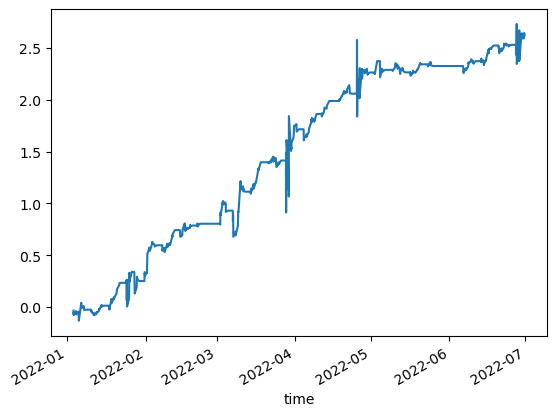

In [18]:
class TradingStrategy:
    def __init__(self, df, threshold):
        self.df = df
        self.threshold = threshold

    def create_proposed_strategy(self):
        trade_df = self.df.copy()
        trade_df['spread_ma5'] = trade_df['spread'].rolling(window=5).mean()
        trade_df['spread_ma20'] = trade_df['spread'].rolling(window=20).mean()

        trade_df['spread_lag'] = trade_df['spread'].shift(1)
        trade_df['spread_mag5_lag'] = trade_df['spread_ma5'].shift(1)
        trade_df['volatility_5_lag'] = trade_df['spread_lag'].rolling(window=5).std()
        trade_df['volatility_20_lag'] = trade_df['spread_lag'].rolling(window=20).std()

        trade_df['spread_log'] = np.log(trade_df['spread'])
        trade_df['spread_exp'] = np.exp(trade_df['spread'])
        trade_df['volatility_5'] = trade_df['spread'].rolling(window=5).std()
        trade_df['volatility_20'] = trade_df['spread'].rolling(window=20).std()
        trade_df['spread_ema_5'] = trade_df['spread'].ewm(span=5).mean()
        trade_df['spread_ema_20'] = trade_df['spread'].ewm(span=20).mean()
        trade_df['roc'] = (trade_df['spread'] / trade_df['spread'].shift(5) - 1) * 100

        trade_df['spread_movement_interaction'] = trade_df['spread'].pct_change() * trade_df['spread_lag'].pct_change()
        trade_df['volatility_ma_interaction'] = trade_df['volatility_5'] * trade_df['volatility_20']
        trade_df['spread_volatility_interaction'] = trade_df['spread'] * trade_df['volatility_5']

        trade_df['rsi_log'] = RSI(trade_df['spread_log'], timeperiod=self.threshold)

        trade_df['rsi_signal'] = 0
        trade_df.loc[trade_df['rsi_log'] > 70, 'rsi_signal'] = -1
        trade_df.loc[trade_df['rsi_log'] < 30, 'rsi_signal'] = 1

        trade_df['rsi_diff'] = trade_df['rsi_log'].diff()

        total_target = (trade_df['rsi_diff'])
        trade_df['target'] = np.where(total_target > 0, -1, np.where(total_target == 0, 1, 0))

        trade_df = trade_df.dropna()
        return trade_df

    def preprocess_data(self):
        trade_df = self.create_proposed_strategy()
        y = trade_df['target']
        X = trade_df.drop([y.name, 'nifty', 'banknifty'], axis=1)
        mi_scores = mutual_info_classif(X, y)
        mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
        mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)
        selected_features = mi_df.nlargest(5, 'Mutual_Information')['Feature'].tolist()
        trade_train = trade_df.loc[:'2021-10-29 15:15:00'].copy()
        trade_test = trade_df.loc['2022-01-03 09:15:00':].copy()
        y_train = trade_train['target']
        X_train = trade_train[selected_features]
        y_test = trade_test['target']
        X_test = trade_test[selected_features]
        return trade_train, trade_test, y_train, X_train, y_test, X_test

    def process_predictions(self, trade_test, y_test, y_pred):
        predictions_df = pd.DataFrame({'spread': trade_test['spread'],'tte': trade_test['tte'],'actual_signal': y_test,
        'Predictions': y_pred,
        'entry_p_l': 0,
        'exit_p_l': 0
            }, index=X_test.index)

        entry_index_long, entry_index_short = None, None
        max_trade_duration = pd.Timedelta(days=5)
        predictions_df['entry_p_l'] = np.where(predictions_df['Predictions'] != 0,
                                               predictions_df['spread'] * (predictions_df['tte']) ** 0.7, 0)

        for index, row in predictions_df.iterrows():
            if row['Predictions'] == 1 and entry_index_long is None:
                entry_index_long = index
            elif row['Predictions'] == -1 and entry_index_long is not None:
                predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                entry_index_long = None
            elif row['Predictions'] == 1 and entry_index_long is not None:
                predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                predictions_df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
                entry_index_long = index

            if row['Predictions'] == -1 and entry_index_short is None:
                entry_index_short = index
            elif row['Predictions'] == 1 and entry_index_short is not None:
                predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                entry_index_short = None
            elif row['Predictions'] == -1 and entry_index_short is not None:
                predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                predictions_df.loc[index, 'entry_p_l'] = row['spread'] * (row['tte']) ** 0.7
                entry_index_short = index

            if entry_index_long or entry_index_short:
                trade_duration = index - entry_index_long if entry_index_long else index - entry_index_short
                if trade_duration >= max_trade_duration:
                    if entry_index_long is not None:
                        predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                        entry_index_long = None
                    elif entry_index_short is not None:
                        predictions_df.loc[index, 'exit_p_l'] = row['spread'] * (row['tte']) ** 0.7
                        entry_index_short = None
        return predictions_df

    def trades(self, entry_df, exit_df):
        result_frames = []
        previous_iteration_entries = pd.Series()

        for _, exit_row in exit_df.iterrows():
            mask = (entry_df.index >= pd.Series(exit_df.index).shift(1).fillna('2021-01-01 09:15:00').loc[0]) & (
                    entry_df.index < exit_row.name)
            filtered_entries = entry_df.loc[mask, ['entry_p_l', 'Predictions']].reset_index()
            new_entries = filtered_entries[~filtered_entries['entry_p_l'].isin(previous_iteration_entries)]
            position = new_entries['Predictions'].max()
            iteration_df = pd.DataFrame({'entry_p_l': [new_entries['entry_p_l'].mean()],
                                         'num_entries': [len(new_entries)],
                                         'position': [position],
                                         'datetime': [filtered_entries.iloc[-1]['time']]})
            result_frames.append(iteration_df)
            previous_iteration_entries = pd.concat([previous_iteration_entries, filtered_entries['entry_p_l']])

        if not result_frames:
            print(f"No trades for shorter_window={shorter_window}, longer_window={longer_window}")

        result_df = pd.concat(result_frames, ignore_index=True)
        result_df.index = exit_df.index
        profit_df = pd.merge(exit_df, result_df, left_index=True, right_index=True)[
            ['exit_p_l', 'entry_p_l_y', 'num_entries', 'position']]
        profit_df['trade_p_l'] = np.where(profit_df['position'] == 1,
                                          profit_df['exit_p_l'] - profit_df['entry_p_l_y'],
                                          np.where(profit_df['position'] == -1,
                                                   profit_df['entry_p_l_y'] - profit_df['exit_p_l'], 0))
        profit_df['trade_return'] = np.where(profit_df['position'] == 1,
                                             (profit_df['exit_p_l'] / profit_df['entry_p_l_y']) - 1,
                                             np.where(profit_df['position'] == -1,
                                                      (profit_df['entry_p_l_y'] / profit_df['exit_p_l']) - 1, 0))
        profit_df['total_p_l'] = profit_df['num_entries'] * profit_df['trade_p_l']
        return profit_df

    def run(self):
        trade_train, trade_test, y_train, X_train, y_test, X_test = self.preprocess_data()
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        y_pred = time_series_cross_validation(model, X_train, y_train, X_test, y_test)

        predictions_df = self.process_predictions(trade_test, y_test, y_pred)
        exit_df = predictions_df[predictions_df['exit_p_l'] != 0]
        entry_df = predictions_df[predictions_df['entry_p_l'] != 0]

        profit_df = self.trades(entry_df, exit_df)

        total_profit = profit_df['total_p_l'].sum()
        sharpe_ratio = calculate_sharpe_ratio(profit_df['total_p_l'], profit_df['trade_return'])
        max_drawdown = calculate_max_drawdown(profit_df['trade_return'])

        profit_df['total_p_l'].cumsum().plot()

        return total_profit, sharpe_ratio, max_drawdown

threshold_value = 7  # from the optimised set of values
trading_strategy = TradingStrategy(df, threshold=threshold_value)
total_profit, sharpe_ratio, max_drawdown = trading_strategy.run()

print("Total Profit:", total_profit)
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)

 While Comparing to the Base strategy, it is noticeable that my proposed strategy is  lacking when it comes to Max Drawdowns but it significantly outperforms with regards to P/L and Sharpe Ratio